In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1, CNN_1D

In [4]:
# load data from sin dataset
data_save_dir = Path("../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [5]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

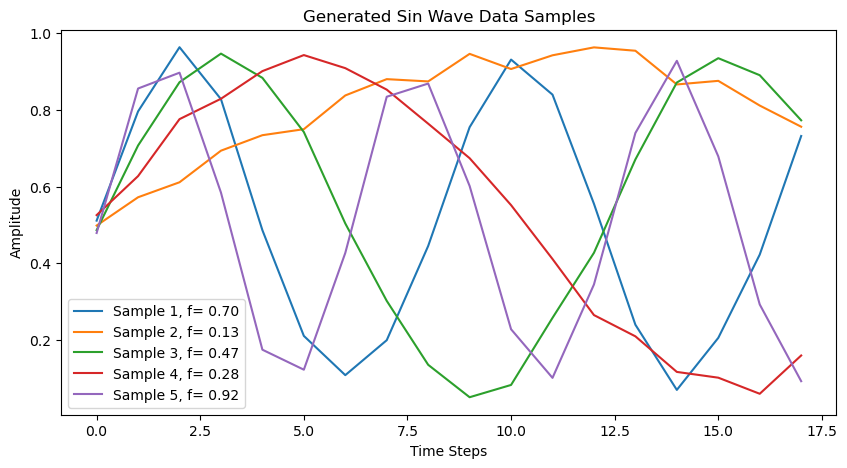

In [6]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [7]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 4),  # =1D kernel size
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 5,
}

CNN_classical = CNN_1D(hparams=hparams)

In [8]:
# change model to float64
CNN_classical = CNN_classical.double()

# number of trainable parameters
n_params = sum(p.numel() for p in CNN_classical.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {n_params}")

Number of trainable parameters: 146


In [9]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical.train()
optimizer = torch.optim.Adam(
    CNN_classical.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical.parameters()]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(
            -1, 1, seq_len
        )
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = CNN_classical(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical.parameters()])
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.6202430879978859


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.1709292898816821


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.15364906718315668


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.09818800227652155


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.08703193359767354


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.09461335399019578


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.09231789448998713


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.06758327822039614


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.08004106585297135


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.07204176913741002


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.0657284240258914


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.05068007466039215


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.046181233670575875


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.042545735139513666


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.04211253002737114


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.03253473837540915


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.03466631898244892


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.027283314492605522


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.028781984218176383


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.025554183204853274


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.028611839454583354


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.032798486028312215


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.03158573748098385


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.02454936615917954


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 train loss: 0.01868831287491825


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 train loss: 0.01791983048182018


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 train loss: 0.018406250511035237


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 train loss: 0.01908216692822361


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 train loss: 0.013832945758147811


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 train loss: 0.019886062319803284


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 train loss: 0.019149412924468024


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 train loss: 0.018722959117765465


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 train loss: 0.01072162660320183


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 train loss: 0.02200529239725872


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 train loss: 0.01965355428266344


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 train loss: 0.013489449979814206


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 train loss: 0.01514891479775585


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 train loss: 0.0150390239998028


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 train loss: 0.016412576729425747


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 train loss: 0.010908100211276715


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 train loss: 0.017495855595261643


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 train loss: 0.017984238393291066


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 train loss: 0.012947396830363805


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 train loss: 0.014657549790955867


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 train loss: 0.013632411584733915


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 train loss: 0.018992597176122474


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 train loss: 0.014447973918070978


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 train loss: 0.014904344261820721


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 train loss: 0.012788299182603593


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 train loss: 0.013471173204276063
Final loss (MSE): 0.003987851002499081
Final loss (RMSE): 0.06314943390481882


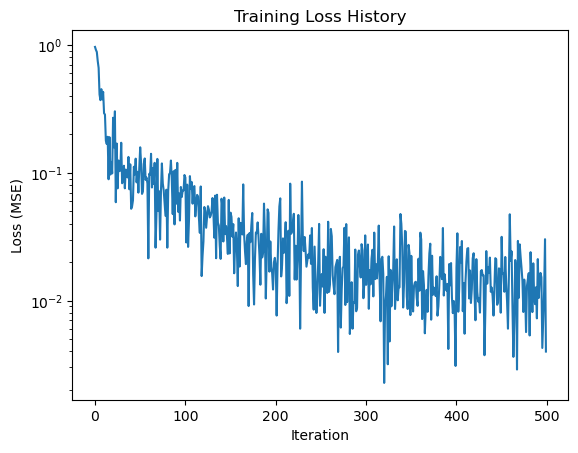

In [10]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

In [11]:
# test the model
CNN_classical.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float64).reshape(-1, 1, seq_len)  # (batch_size, 1, seq_len)
    y_test_tmp = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
    predicted = CNN_classical(x_test).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp)
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.004920715048695969
Test loss (RMSE): 0.07014780858085283


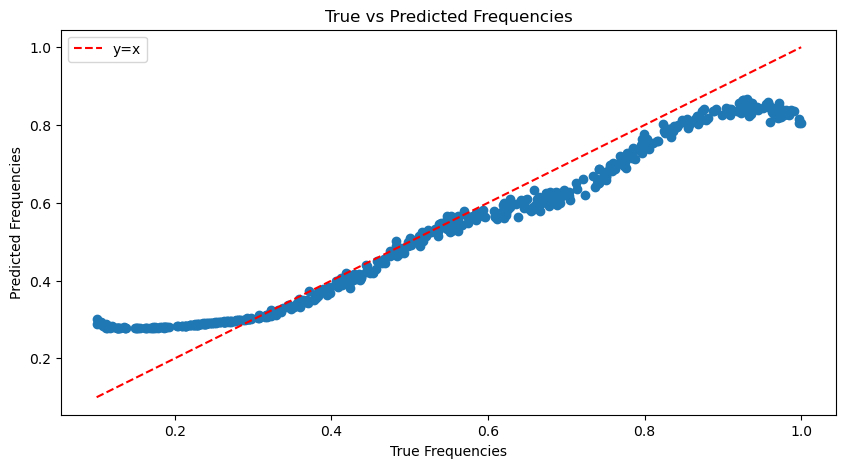

In [12]:
# plot the results
plt.figure(figsize=(10, 5))
plt.scatter(y_test_tmp, predicted.numpy())
# diagonal line
plt.plot([y_test_tmp.min(), y_test_tmp.max()], [y_test_tmp.min(), y_test_tmp.max()], 'r--', label='y=x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("True Frequencies")
plt.ylabel("Predicted Frequencies")
plt.legend()
plt.show()

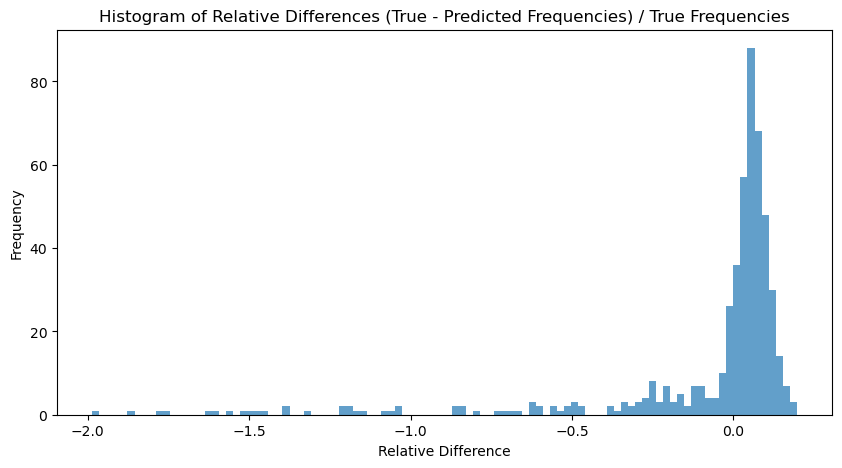

In [13]:
diffs = y_test.squeeze(1) - y_pred_test
rel_diffs = diffs / y_test.squeeze(1)  # relative differences
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(rel_diffs, bins=100, alpha=0.7)
plt.title("Histogram of Relative Differences (True - Predicted Frequencies) / True Frequencies")
plt.xlabel("Relative Difference")
plt.ylabel("Frequency")
plt.show()

In [14]:
import pickle
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/classical_CNN_kernel_size_4_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            test_loss.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

# With Learned Channel Collapse

In [15]:
from source.NAHEA_CNN import CNN_1D_Learned_Channel_Collapse

In [16]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 4),  # =1D kernel size
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 4,
}

CNN_classical_2 = CNN_1D_Learned_Channel_Collapse(hparams=hparams)
CNN_classical_2 = CNN_classical_2.double()

In [17]:
n_params = sum(p.numel() for p in CNN_classical_2.parameters() if p.requires_grad)
print(f"Number of learned parameters: {n_params}")

Number of learned parameters: 146


In [18]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical_2.train()
optimizer = torch.optim.Adam(
    CNN_classical_2.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical_2.parameters()]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(
            -1, 1, seq_len
        )
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = CNN_classical_2(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical_2.parameters()])
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.2329321664468516


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.14129678221445313


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.12068648156117016


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.0974592188036936


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.10212192196299848


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.08015962298575537


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.06493321849519247


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.06203812522394453


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.052124154238104584


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.050459654048490496


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.04298712559113921


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.029620027564725544


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.020722528412923515


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.02873937524392419


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.016811068090875056


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.014252895956044152


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.02191597509010817


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.014011400605486269


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.012781379085733782


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.022212618149989493


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.013221128593434855


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.01217581259655923


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.012548383033692979


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.009064146254202914


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 train loss: 0.012796826026969365


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 train loss: 0.009074459167199784


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 train loss: 0.01256109309938827


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 train loss: 0.010468478835866412


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 train loss: 0.009231685654909406


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 train loss: 0.01291139968310272


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 train loss: 0.010324785640434124


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 train loss: 0.007944439878537147


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 train loss: 0.007183376659864108


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 train loss: 0.00824240017577057


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 train loss: 0.010904522228359869


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 train loss: 0.007497833696282251


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 train loss: 0.01091271416235301


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 train loss: 0.011796956236951308


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 train loss: 0.009371577509202108


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 train loss: 0.006478012729062671


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 train loss: 0.008153899459181692


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 train loss: 0.008040221306295748


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 train loss: 0.009161067422318583


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 train loss: 0.008041182542411754


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 train loss: 0.00810547662713353


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 train loss: 0.007171298442418332


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 train loss: 0.008561525709094981


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 train loss: 0.008334530651122139


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 train loss: 0.007420926366012849


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 train loss: 0.0058539581738227845
Final loss (MSE): 0.0013639787544162407
Final loss (RMSE): 0.036932082995902636


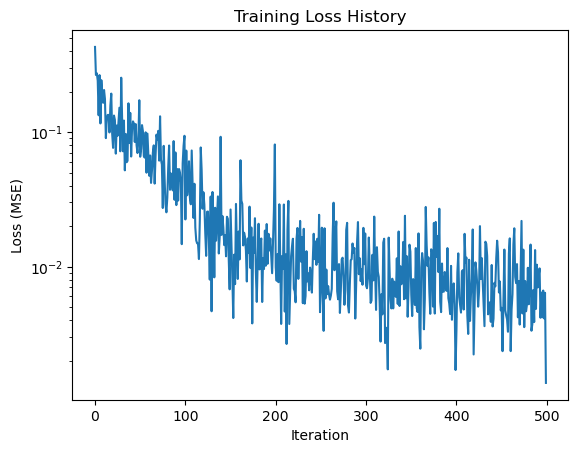

In [19]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

In [20]:
# test the model
CNN_classical_2.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float64).reshape(-1, 1, seq_len)  # (batch_size, 1, seq_len)
    y_test_tmp = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
    predicted = CNN_classical_2(x_test).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp)
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.0030819114777613206
Test loss (RMSE): 0.05551496625020429


In [21]:
import pickle
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/classical_CNN_kernel_size_4_Learned_Channel_Collpase_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            test_loss.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )